In [196]:
%matplotlib inline

from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

import sklearn
import yuv

# Video loading

In [47]:
# NOTE(ajayjain): This list may be missing a video
videos = [
    "./data/live/rh1_25fps.yuv",
    "./data/live/st1_25fps.yuv",
    "./data/live/pa1_25fps.yuv",
    "./data/live/tr1_25fps.yuv",
    "./data/live/bs1_25fps.yuv",
    "./data/live/mc1_50fps.yuv",
    "./data/live/sf1_25fps.yuv",
    "./data/live/rb1_25fps.yuv",
    "./data/live/sh1_50fps.yuv",
    "./data/live/pr1_50fps.yuv",
]

# Frame dimensions
dim = (768, 432)

In [7]:
video_matrix, frames = yuv.load_YUV420_video(videos[0], dim)

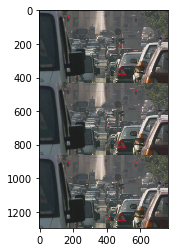

In [8]:
rgb_frames = yuv.convert_pil_ycbcr_to_rgb(frames)
stacked_frames = np.concatenate(rgb_frames)
plt.imshow(stacked_frames[:dim[1]*3, :, :])

In [52]:
def frame_vector_to_rgb(frame, dimensions):
    """Converts a image vector an RGB numpy array.
   
    Args:
        frame: vector of YUV data, scaled from 0 to 1
        dimensions: tuple/list/ndarray containing the width and height of the desired frame
    """
    Y_components = dimensions[0] * dimensions[1]
    U_components = Y_components // 4
    V_components = Y_components // 4
    
    UV_dimensions = (dimensions[0] // 2, dimensions[1] // 2)
   
    frame = np.uint8(frame * 255)

    y = Image.frombytes('L', dimensions, frame[:Y_components])
    u = Image.frombytes('L', UV_dimensions, frame[Y_components:Y_components+U_components])\
             .resize(dimensions)
    v = Image.frombytes('L', UV_dimensions, frame[Y_components+U_components:Y_components+U_components+V_components])\
             .resize(dimensions)

    image = Image.merge('YCbCr', (y, u, v)).convert('RGB')
    return image

# Non-negative matrix factorization of video byte matrix

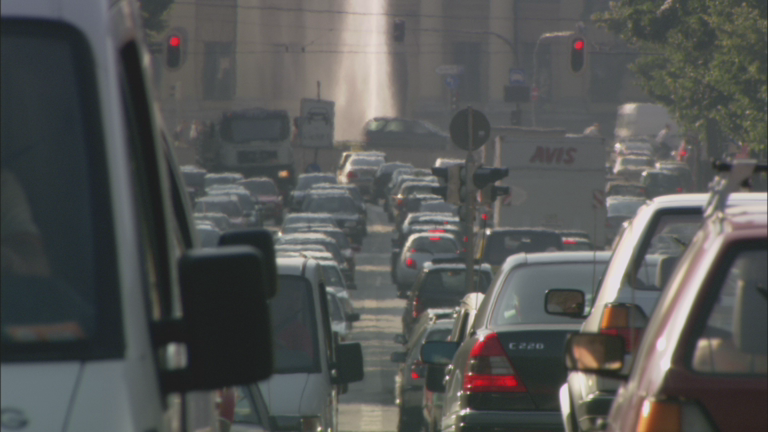

In [58]:
# Transpose video matrix: num frames by num components
frames = video_matrix.T
# Scale from 0 to 1
frames = frames.astype(np.float32) / 255.

frame_vector_to_rgb(frames[0], dim)

# eps = 1e-5
# frame_mean = frames.mean(axis=0)
# frame_std = frames.std(axis=0) + eps
# frames = (frames - frame_mean) / frame_std

In [109]:
nmf30 = nmf
W30 = W
H30 = H

In [224]:
nmf = sklearn.decomposition.NMF(n_components=10, verbose=True)
W = nmf.fit_transform(frames)

violation: 1.0
violation: 0.4878496861233268
violation: 0.3582349757188362
violation: 0.27952764138065694
violation: 0.21788807512981262
violation: 0.17616475038251594
violation: 0.1472984764659149
violation: 0.1264544637109143
violation: 0.11109283356851904
violation: 0.09924505659476789
violation: 0.08985438502365246
violation: 0.08211071469033392
violation: 0.07575014918794183
violation: 0.07046074872044286
violation: 0.06610238829193651
violation: 0.062345367524179185
violation: 0.059061930155937935
violation: 0.05617566179987112
violation: 0.053591809375566964
violation: 0.051262876635738794
violation: 0.04915529099173411
violation: 0.047191677494102774
violation: 0.04536399132160168
violation: 0.04365162727378901
violation: 0.042037787911344535
violation: 0.04050144626506123
violation: 0.0390443534111638
violation: 0.03764942866172151
violation: 0.03632195798870836
violation: 0.03505780239776484
violation: 0.033846278889719576
violation: 0.03268847699597839
violation: 0.031590769

In [225]:
H = nmf.components_

In [226]:
# W_uint8 = np.uint8(W * 255)
# H_uint8 = np.uint8(H * 255)

In [227]:
# reconstructed = (W_uint8.astype(np.float32) / 255.) @ (H_uint8.astype(np.float32) / 255.)
reconstructed = np.float16(W) @ np.float16(H)
# frame_vector_to_rgb(reconstructed[0], dim)

In [228]:
# frame_vector_to_rgb(frames[1], dim)

In [229]:
bytes_to_transmit = W.shape[0] * W.shape[1] * 2 + H.shape[0] * H.shape[1] * 2
original_bytes = video_matrix.shape[0] * video_matrix.shape[1]
compression_ratio = bytes_to_transmit / float(original_bytes)

bits_per_pixel = bytes_to_transmit * 8 / (dim[0] * dim[1] * video_matrix.shape[1])
original_bits_per_pixel = original_bytes * 8 / (dim[0] * dim[1] * video_matrix.shape[1])

print("Compressed bits/px: {:.3f}".format(bits_per_pixel))
print("Original bits/px:   {:.3f}".format(original_bits_per_pixel))
print("Compression ratio:  {:.3f}".format(compression_ratio))

Compressed bits/px: 0.960
Original bits/px:   12.000
Compression ratio:  0.080


/home/ajay/.virtualenvs/compression/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


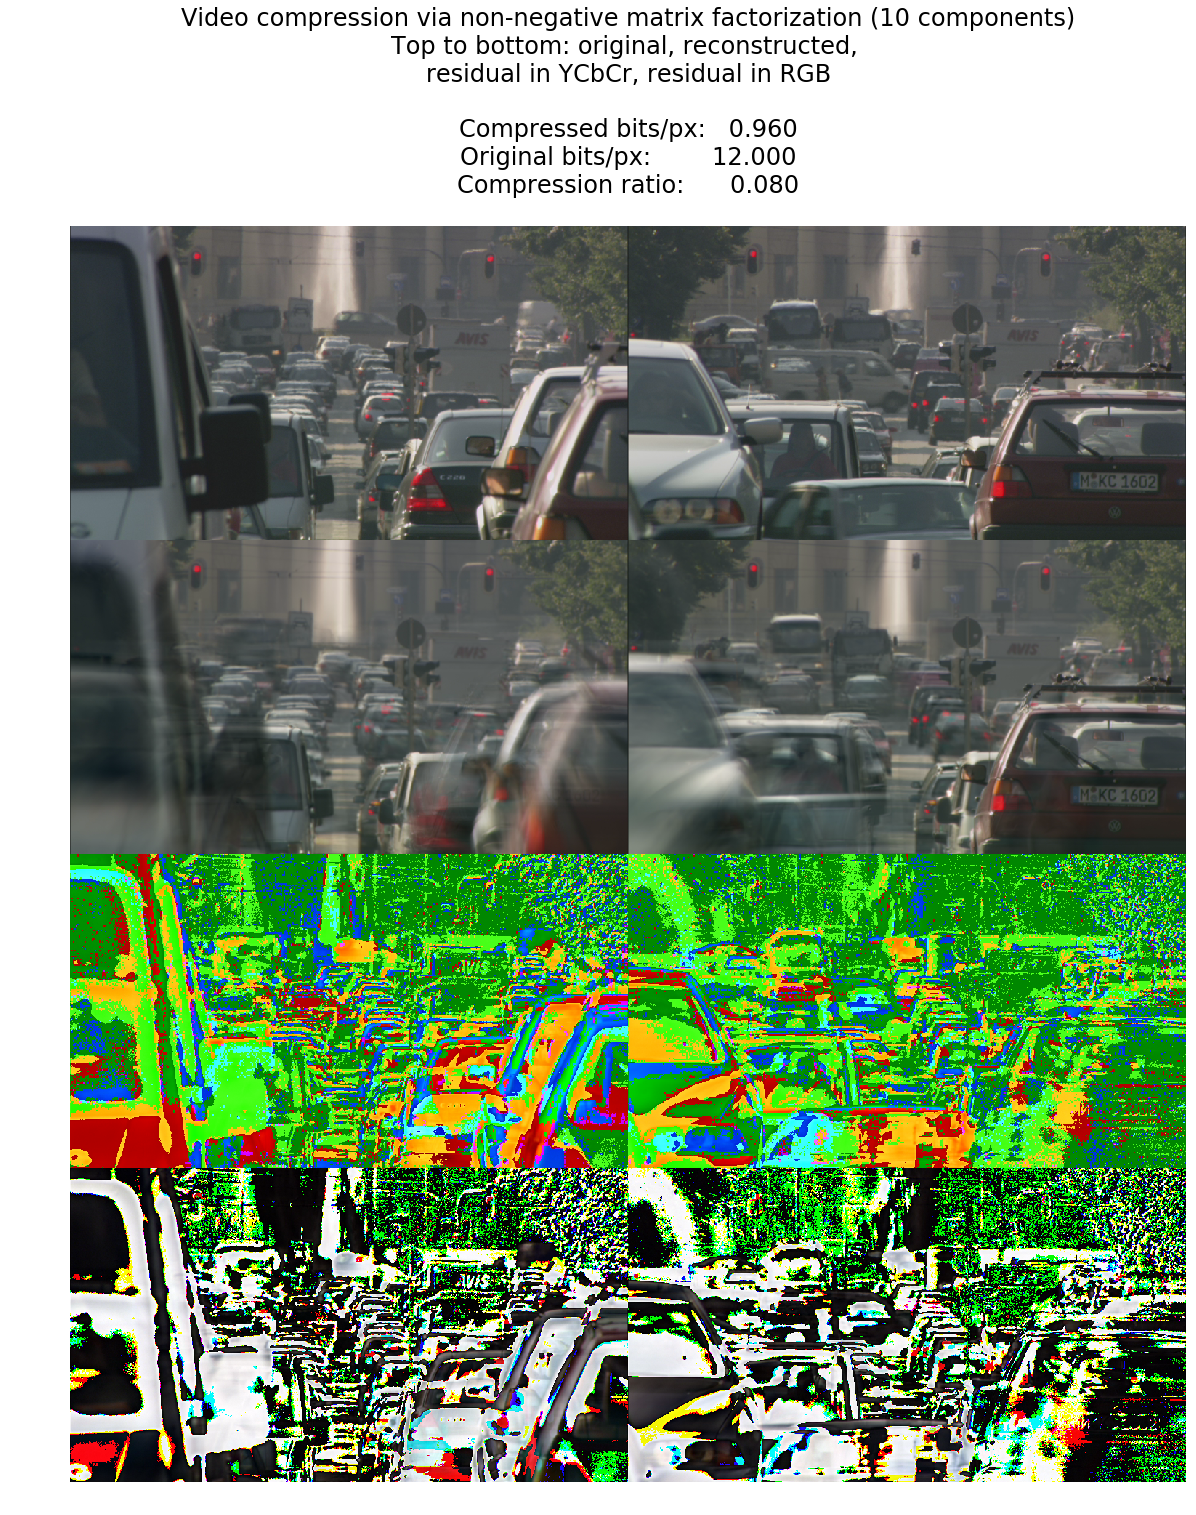

In [230]:
reconstructed_and_original = (
    frame_vector_to_rgb(reconstructed[0], dim),
    frame_vector_to_rgb(frames[0], dim)
)

plt.figure(figsize=(20, 30))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
title = "Video compression via non-negative matrix factorization (10 components)\n" +\
        "Top to bottom: original, reconstructed, \nresidual in YCbCr, residual in RGB\n\n" +\
        "Compressed bits/px:   {:.3f}\n".format(bits_per_pixel) +\
        "Original bits/px:        {:.3f}\n".format(original_bits_per_pixel) +\
        "Compression ratio:      {:.3f}\n".format(compression_ratio)
plt.title(title)
plt.axis("off")
plt.imshow(
    np.hstack((
        np.vstack((
            frame_vector_to_rgb(frames[0], dim),
            frame_vector_to_rgb(reconstructed[0], dim),
            frame_vector_to_rgb(frames[0] - reconstructed[0], dim),
            np.asarray(frame_vector_to_rgb(frames[0], dim)) - np.asarray(frame_vector_to_rgb(reconstructed[0], dim)),
        )),
        np.vstack((
            frame_vector_to_rgb(frames[-1], dim),
            frame_vector_to_rgb(reconstructed[-1], dim),
            frame_vector_to_rgb(frames[-1] - reconstructed[-1], dim),
            np.asarray(frame_vector_to_rgb(frames[-1], dim)) - np.asarray(frame_vector_to_rgb(reconstructed[-1], dim)),
        )),
    ))
)

plt.savefig("nmf.png")

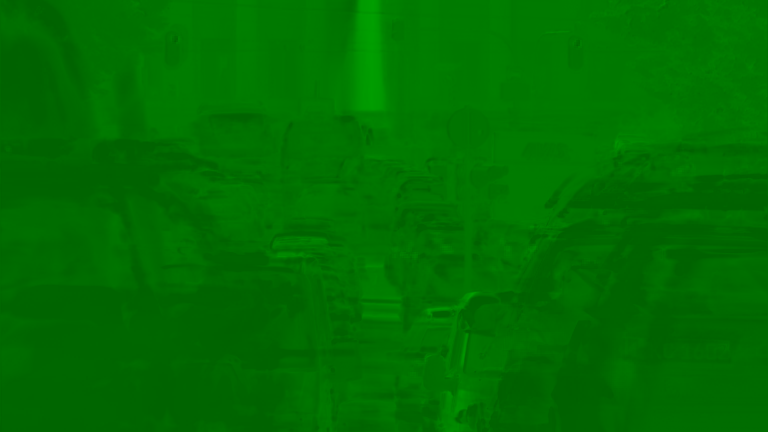

In [231]:
frame_vector_to_rgb(H[0], dim)

In [ ]:
np.sum((frames - reconstructed)**2)

In [91]:
np.sum((frames[:30, :] - reconstructed)**2)

1058.8999911841145